#Setup

In [ ]:
!pip install scikit-optimize
!pip install joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
from skopt import BayesSearchCV
from keras.datasets import fashion_mnist
import joblib

SEED = 42

#Data Preparation
(a) Data cleansing and transformation  
(b) Data splitting (i.e., training, validation, and test splits)

In [ ]:
# Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten the images and scale pixel values to mean=0.0 and var=1.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_train= (X_train - np.mean(X_train)) / np.std(X_train)

# Flatten the images and scale pixel values to mean=0.0 and var=1.0
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)


#Cross Validation split
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
data_splits = stratified_kfold.split(X=X_train, y=y_train)



#Model building

##(a) Algorithm selection : XGBoost Vanilla
Developing a vanilla XGBoost model and validating using 5 fold Stratified cross-validation.  
Model evaluation on the test set using proper evaluation metrics and qualitative analysis.




XGBoost model with default parameters:

Test Accuracy: 89.69%
Precision: 0.8965
Recall: 0.8969
F1-Score: 0.8965


Confusion Matrix:


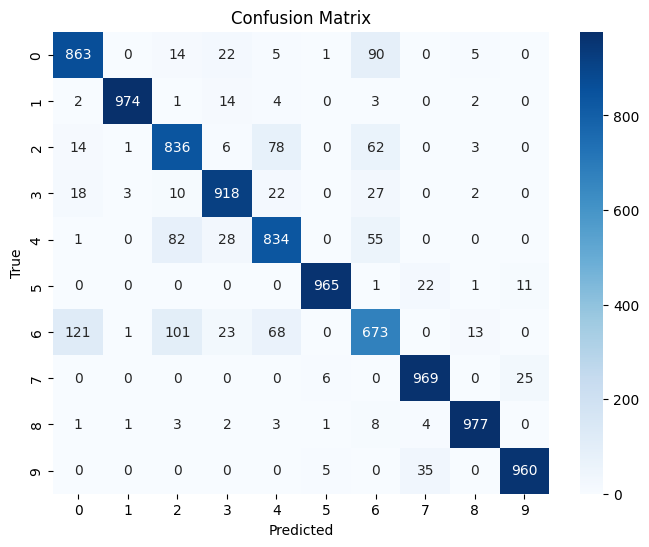

In [ ]:
# Initialize the XGBoost classifier with default parameters
default_model = xgb.XGBClassifier(seed=SEED)

# Fit the model on the entire training set
default_model.fit(X_train, y_train)

# Predictions on the test set
y_test_pred = default_model.predict(X_test)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n" + "="*40 + "\n")
print("\nXGBoost model with default parameters:\n")

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Saving the default model as joblib files

In [ ]:
joblib.dump(default_model, 'xgboost_classifier_default.joblib')

['xgboost_classifier_default.joblib']

In [ ]:
# Classification Report
class_report = classification_report(y_test, y_test_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.84      0.82      1000
           3       0.91      0.92      0.91      1000
           4       0.82      0.83      0.83      1000
           5       0.99      0.96      0.98      1000
           6       0.73      0.67      0.70      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



##(b) Model building: Hyper-Parameter Tuning
Finding the best hyperparameters using Bayesian optimization and cross-validation metrics.  
Model is built on whole training set using the best hyper_parameters.  
Model evaluation on the test set using proper evaluation metrics and qualitative analysis.

In [ ]:
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softprob', num_class=10, seed=SEED)

# Hyperparameter tuning using Bayesian optimization
param_space = {
    'learning_rate': (0.1, 0.5),
    'max_depth': (8, 12),
    'n_estimators': (70, 130),
    'subsample': (0.5, 1.0),
    'min_child_weight': (0, 4),
}

bayes_opt = BayesSearchCV(
    xgb_classifier,
    param_space,
    n_iter=15,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring='accuracy', # Accuracy as metric
    verbose=10,  # Adjust verbosity level (0 for no output, higher integers for more details)
)

bayes_opt.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.27741698265128945, max_depth=10, min_child_weight=2, n_estimators=116, subsample=0.8251291379552849
[CV 1/5; 1/1] END learning_rate=0.27741698265128945, max_depth=10, min_child_weight=2, n_estimators=116, subsample=0.8251291379552849;, score=0.907 total time= 2.8min
[CV 2/5; 1/1] START learning_rate=0.27741698265128945, max_depth=10, min_child_weight=2, n_estimators=116, subsample=0.8251291379552849
[CV 2/5; 1/1] END learning_rate=0.27741698265128945, max_depth=10, min_child_weight=2, n_estimators=116, subsample=0.8251291379552849;, score=0.904 total time= 2.7min
[CV 3/5; 1/1] START learning_rate=0.27741698265128945, max_depth=10, min_child_weight=2, n_estimators=116, subsample=0.8251291379552849
[CV 3/5; 1/1] END learning_rate=0.27741698265128945, max_depth=10, min_child_weight=2, n_estimators=116, subsample=0.8251291379552849;, score=0.903 total time= 2.8min
[CV 4/5; 1/1] START learning_rat

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_ty...
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_class=10,
                                      num_parallel_tree=None, ...),
              n_iter=15, scoring='accuracy',
              search_spaces={'learning_rate': (0.1, 0.5), 'max_depth': (8, 12),
                             'min_child_weight': (0, 4),
                             'n_estimators': (70, 130),
                             'subsample': (0.5, 1.0)},
              verbose=10)

In [ ]:
# Access the cross-validation results
cv_results = bayes_opt.cv_results_

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Mean Score': cv_results['mean_test_score'],
    'Std Dev Score': cv_results['std_test_score'],
    'Params': cv_results['params']
})

results_df = results_df.sort_values(by='Mean Score', ascending=False)
header = ["Index", "Mean Score", "Std Dev Score", "Params"]
results_df.index.name = "Index"
results_df.reset_index(inplace=True)

# Display the cross-validation results
print(results_df.to_markdown(headers=header, index=False))
print("\n" + "="*40 + "\n")


# Print the best hyperparameters
best_params = bayes_opt.best_params_
print("Best Hyperparameters:", best_params)

|   Index |   Mean Score |   Std Dev Score | Params                                                                                                                                                      |
|--------:|-------------:|----------------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------|
|       0 |     0.904483 |     0.00132644  | OrderedDict([('learning_rate', 0.27741698265128945), ('max_depth', 10), ('min_child_weight', 2), ('n_estimators', 116), ('subsample', 0.8251291379552849)]) |
|       2 |     0.904267 |     0.000866667 | OrderedDict([('learning_rate', 0.26944684801074714), ('max_depth', 10), ('min_child_weight', 3), ('n_estimators', 128), ('subsample', 0.7968700380184629)]) |
|      11 |     0.90405  |     0.000863777 | OrderedDict([('learning_rate', 0.31694105708750187), ('max_depth', 12), ('min_child_weight', 2), ('n_estimators', 123), ('subsample', 0.9959818

##(c) Model evaluation

Test Accuracy: 89.80%
Test Precision: 0.8973
Test Recall: 0.8980
Test F1-Score: 0.8973


Confusion Matrix:


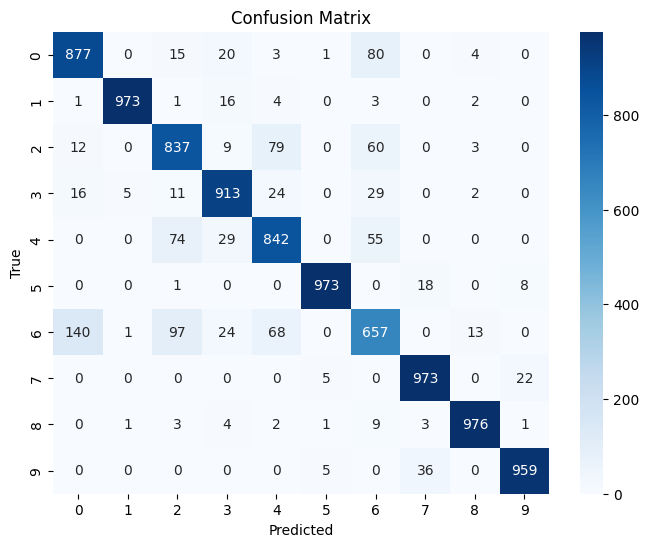

In [ ]:
# Train the model on the whole training set using the best hyperparameters
best_model = bayes_opt.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)

# Calculate evaluation metrics on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Test F1-Score: {f1_test:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

##(d) XGBoost Hyper-tuned Classifer

In [ ]:
hyperparameters = {'learning_rate': 0.27741698265128945,
                   'max_depth': 10,
                   'min_child_weight': 2,
                   'n_estimators': 116,
                   'subsample': 0.8251291379552849,
                   'seed': SEED,
                   'objective' : 'multi:softprob',
                   'num_class':10
                   }

# Initialize the XGBoost classifier with best parameters
xgb_best_model = xgb.XGBClassifier(**hyperparameters)

# Fit the model on the entire training set
xgb_best_model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27741698265128945,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=116, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)

In [ ]:
joblib.dump(xgb_best_model, 'xgboost_classifier_hypertuned.joblib')

['xgboost_classifier_hypertuned.joblib']

#Interpretability
Feature Importance:


Feature Importance:
         Feature  Importance
337  feature_337    0.070449
346  feature_346    0.041199
471  feature_471    0.039846
490  feature_490    0.031988
339  feature_339    0.024943
..           ...         ...
56    feature_56    0.000000
54    feature_54    0.000000
27    feature_27    0.000000
26    feature_26    0.000000
0      feature_0    0.000000

[784 rows x 2 columns]


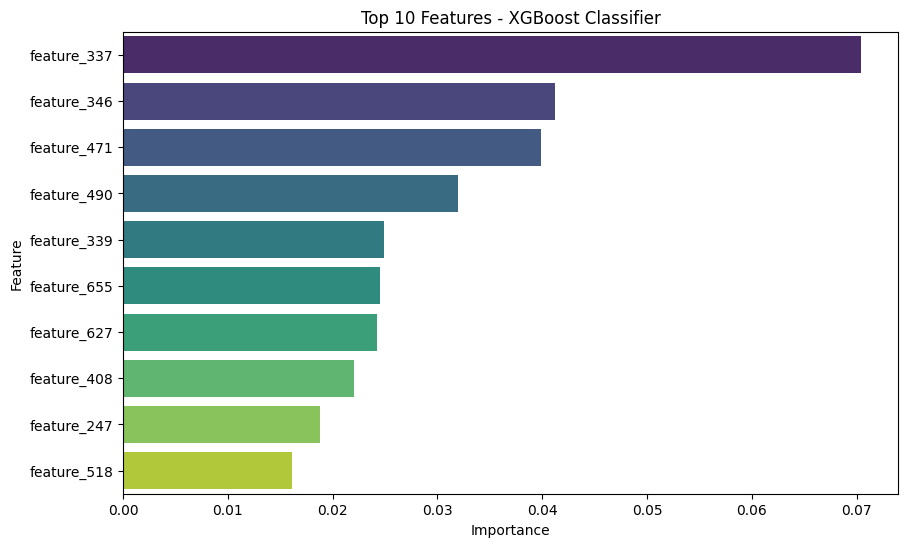

In [ ]:


# Get feature importances from the trained model
feature_importances = xgb_best_model.feature_importances_

# If X_train is a NumPy array and doesn't have columns, create a list of feature names
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance table
print("\nFeature Importance:")
print(feature_importance_df)

# Plot the top N important features horizontally using Seaborn
top_n = 10  # Change this value to display a different number of top features
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bar_plot = sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Features - XGBoost Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()